In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

##### For camera calibration, a set of chessboard images are chosen. These images have 9 inner points in x direction and 6 inner points in y direction. objp matrix is initialized with sequence values using numpy's mgrid function. OpenCV's findChessboardCorners is used to identify the imgpoints. Then OpenCV's calibrateCamera function is used to calibrate the camera to remove distortions. The mtx and dist matrices returned by calibrateCamera function are used to remove the distortions in images.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)



In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/CALI*.jpg')
imgshape = None

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    imgshape = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

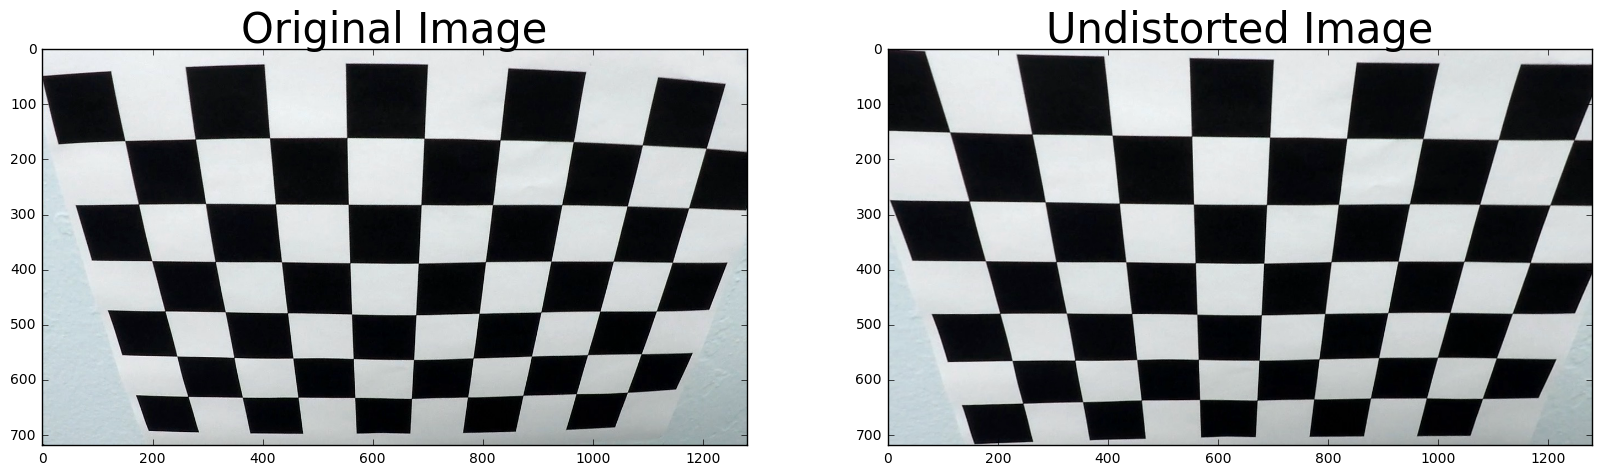

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/test_image.jpg')
img = cv2.resize(img,(imgshape[1],imgshape[0]) )
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',undist)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle_new.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

##### OpenCv's undistort function is used to remove edge distortions. We can see in the above images that the edge distortions in camera images are removed.

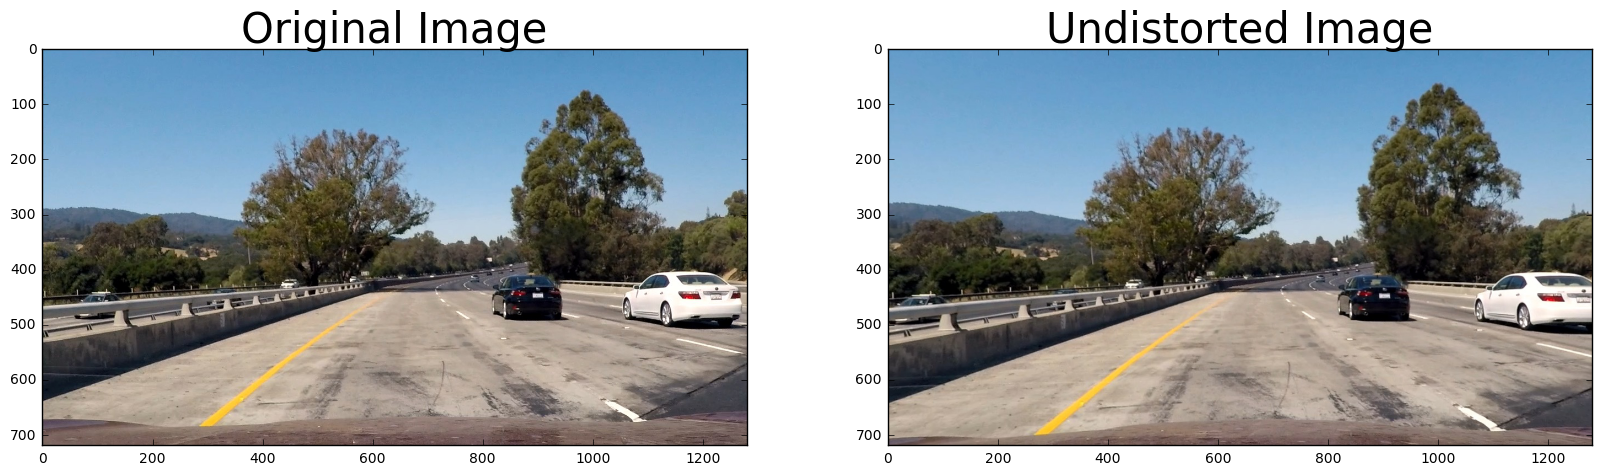

In [5]:
# Test undistortion on an image
img = cv2.imread('test_images/test1.jpg')
img = cv2.resize(img,(imgshape[1],imgshape[0]) )
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dist_pickle = {}
with open("camera_cal/wide_dist_pickle_new.p", mode='rb') as f:
    dist_pickle = pickle.load(f)

#savedMtx = ""
#savedDist = ""

savedMtx = np.float64(dist_pickle["mtx"])
savedDist = np.float64(dist_pickle["dist"])


#undist2 = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('test_images/test2_undist.jpg',undist)

undist = cv2.undistort(img, savedMtx, savedDist, None, savedMtx)
cv2.imwrite('test_images/test2_undist.jpg',undist)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


##### Earlier generated mtx and dist matrices are used in undistort function to remove distortions in actual images to be used later in video. We can see in the above right image that distortions are removed near white car rear on the right side and near the other car on the other side of road on the left side of image.

##### Following functions are used to create a binary image to finally filter the lane lines

In [6]:
ksize = 3

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0])  & (scaled_sobel <= thresh[1]) ] = 1
    
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [8]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1     
    
    return mag_binary

In [9]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1       
    return dir_binary

In [10]:
def color_threshold(image, sobel_kernel=3, threshS=(0, np.pi/2),threshV=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    #thresh = (100, 255)#90,255
    binary_S = np.zeros_like(S)
    binary_S[(S > threshS[0]) & (S <= threshS[1])] = 1
    
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hls[:,:,0]
    S = hls[:,:,1]
    V = hls[:,:,2]

    #thresh = (50, 255)
    binary_V = np.zeros_like(S)
    binary_V[(V > threshV[0]) & (V <= threshV[1])] = 1
    
    combined_SV = np.zeros_like(binary_S)
    combined_SV[((binary_S == 1) & ((binary_V == 1)))] = 1
    
    return combined_SV  


##### Combination of sobel threshold for x and y axis and (S of HLS) and (V of HSV) tranforms are used to generate a binary image.

In [11]:
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(12, 255)) #80,100
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(25, 255)) #80,120
#mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(60, 255))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

color_binary = color_threshold(img, sobel_kernel=ksize, threshS = (100,255), threshV = (50,255))

combined_SVgradXY = np.zeros_like(gradx)
combined_SVgradXY[((gradx == 1) & (grady == 1)) | ((color_binary == 1))] = 255    

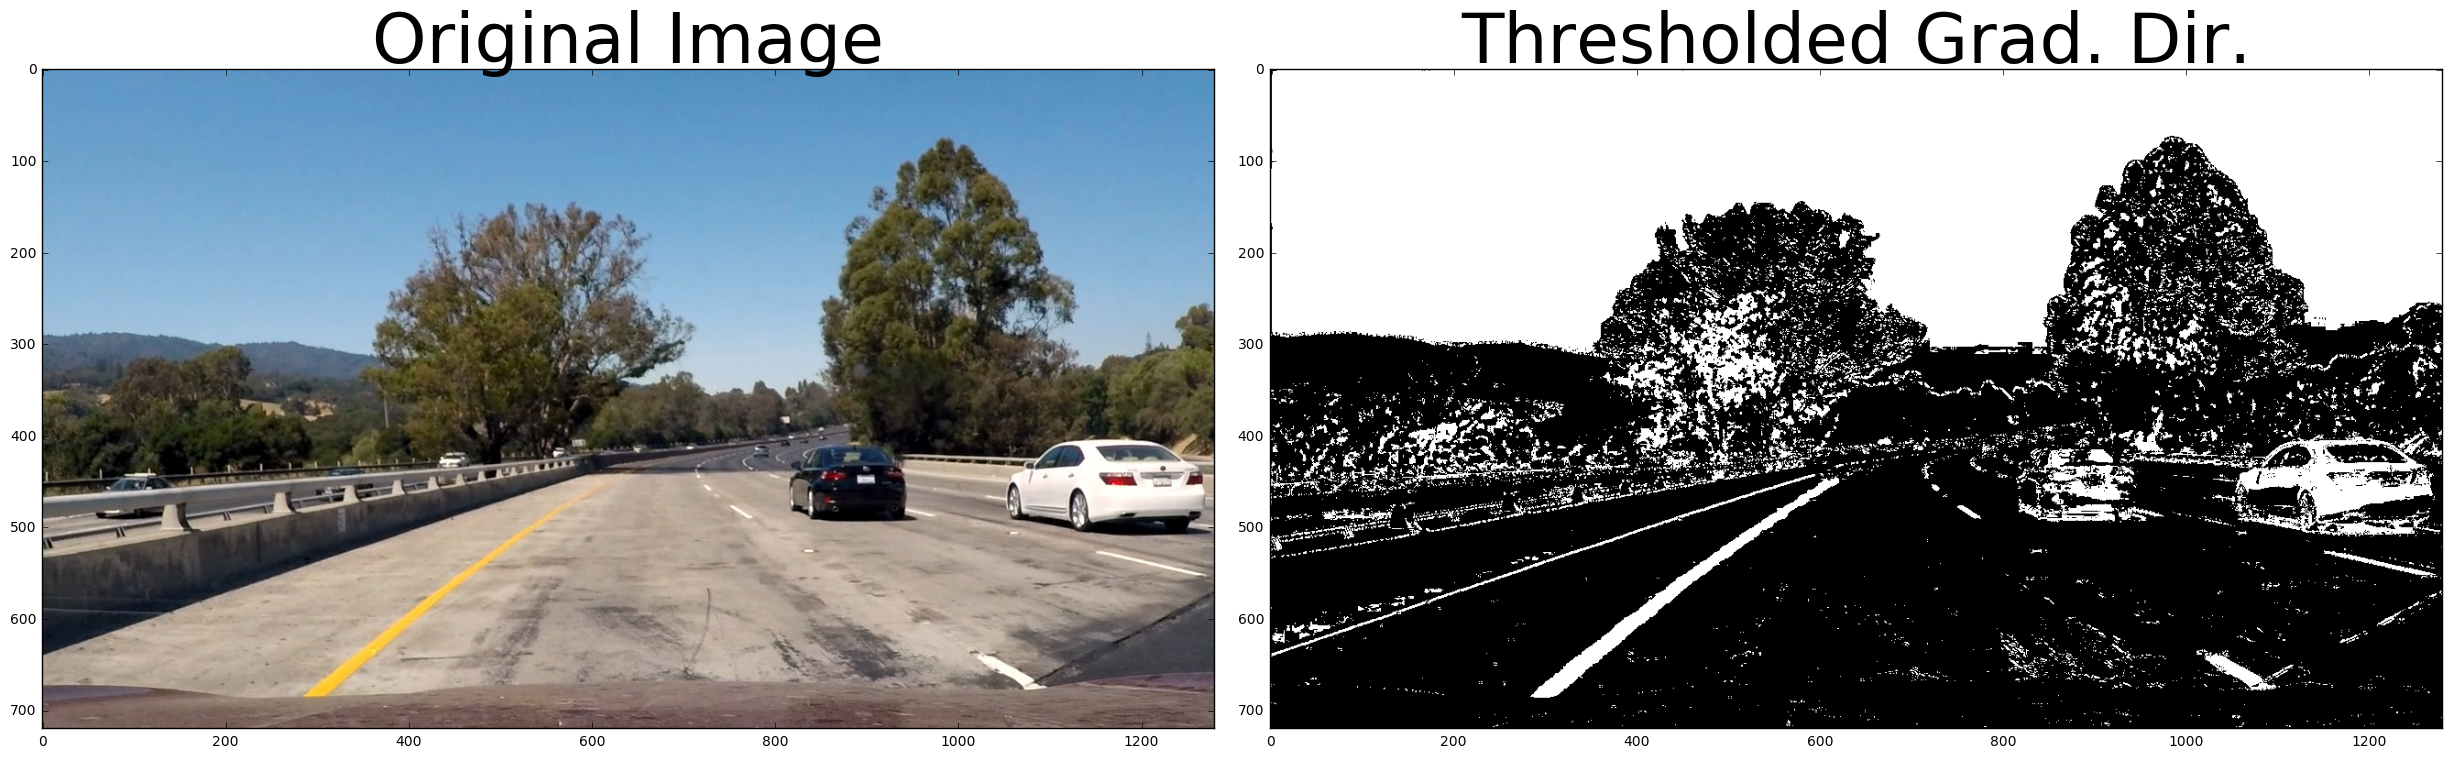

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_SVgradXY, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

##### Following warper function is used to undistort the image and create perspective transform. This function returns the binary image after perspective transform and also returns the Inverse transform matrix to be used later to map lane lines on the main image.

In [13]:
def warper(img, nx, ny, src,dest,mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    M = cv2.getPerspectiveTransform(np.array(src), np.array(dest))
    MInv = cv2.getPerspectiveTransform(np.array(dest), np.array(src))
 
    warped = cv2.warpPerspective(undist, M, img_size,flags=cv2.INTER_NEAREST)  

    return warped, M, MInv

##### Src and destination points for the perspective transform

In [14]:
#src_in = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
#dst_in = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])    

#working
#src_in = np.float32([[585, 460], [303, 705], [1027, 705], [695, 460]])
#dst_in = np.float32([[320, 0], [320, 700], [960,700], [960, 0]])  

src_in = np.float32([[585, 460], [303, 705], [1100, 705], [725, 460]])
dst_in = np.float32([[320, 0], [320, 700], [1000,700], [1000, 0]]) 

In [15]:
warped = warper(combined_SVgradXY, nx, ny, src_in, dst_in, mtx, dist) 

In [16]:
binary_warped = warped[0]
M = warped[1]
MInv = warped[2]

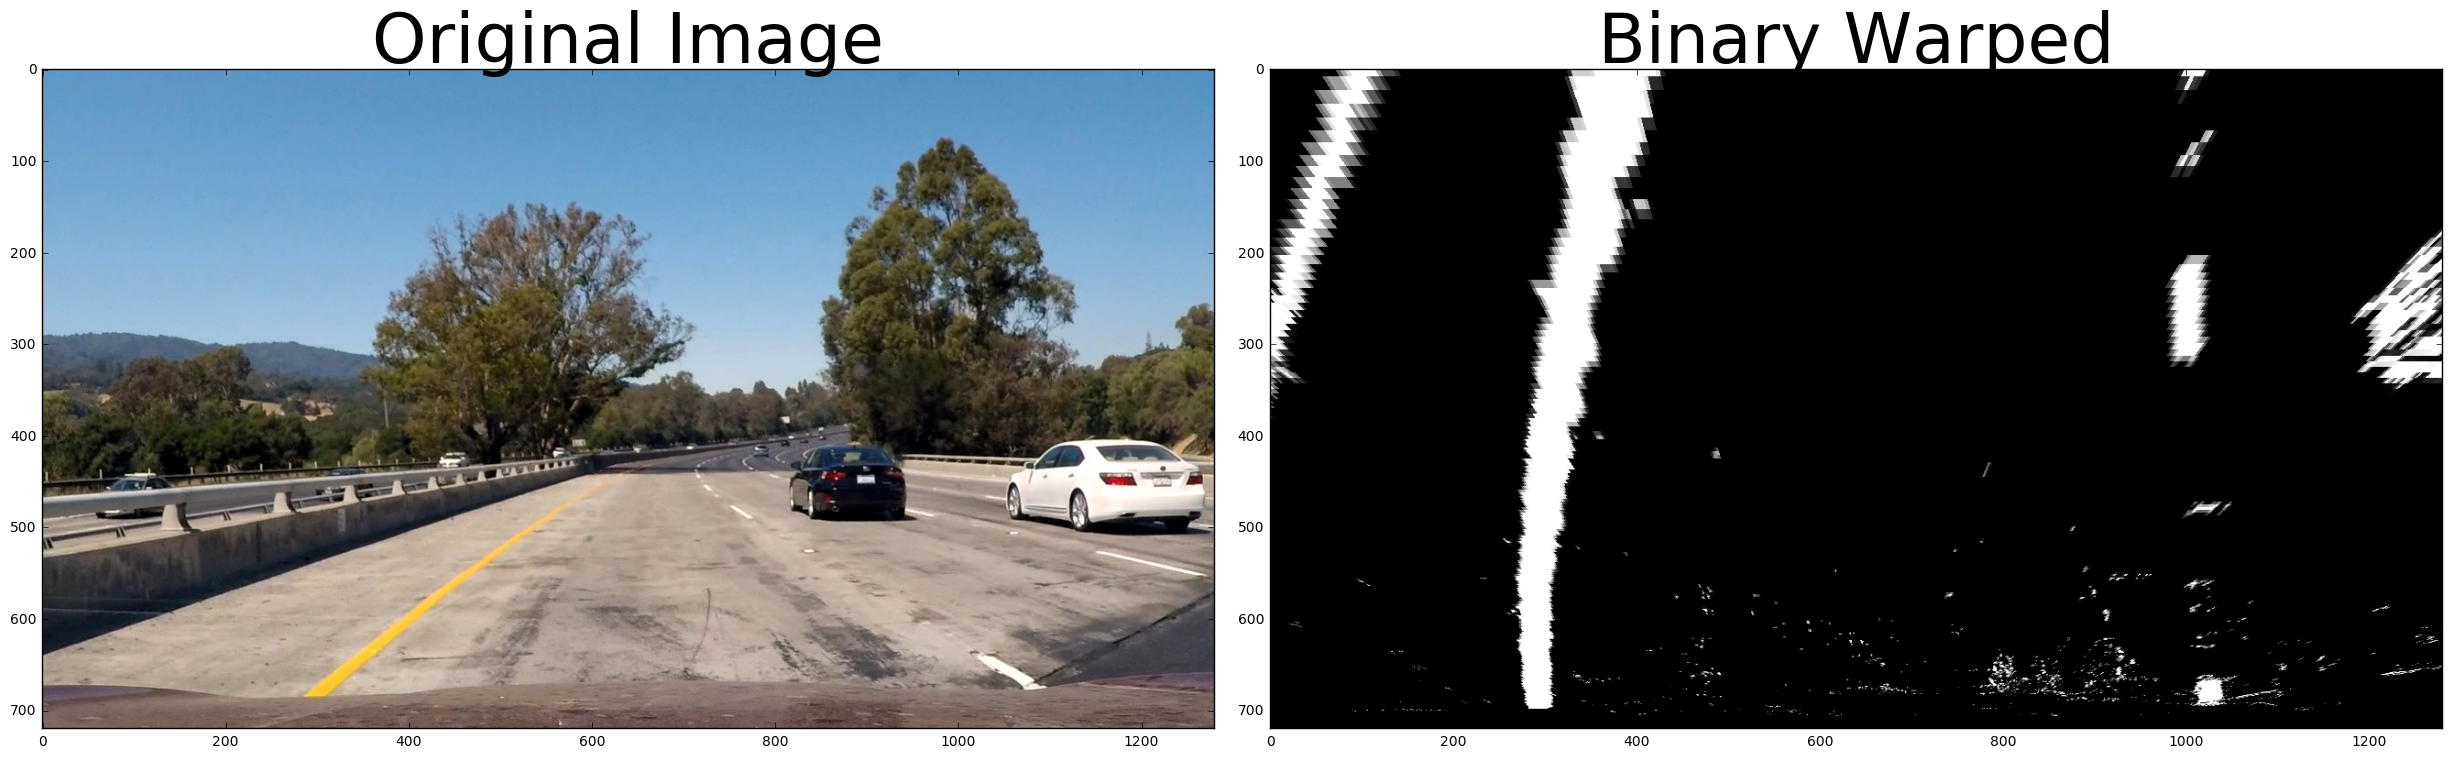

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [18]:
warpedImage = warper(img, nx, ny, src_in, dst_in, mtx, dist) 

In [19]:
img_warped = warpedImage[0]
imgM = warped[1]
imgMInv = warped[2]

##### Following image shows the src points on the original image and dest points on the warped image ( using perspective transform)

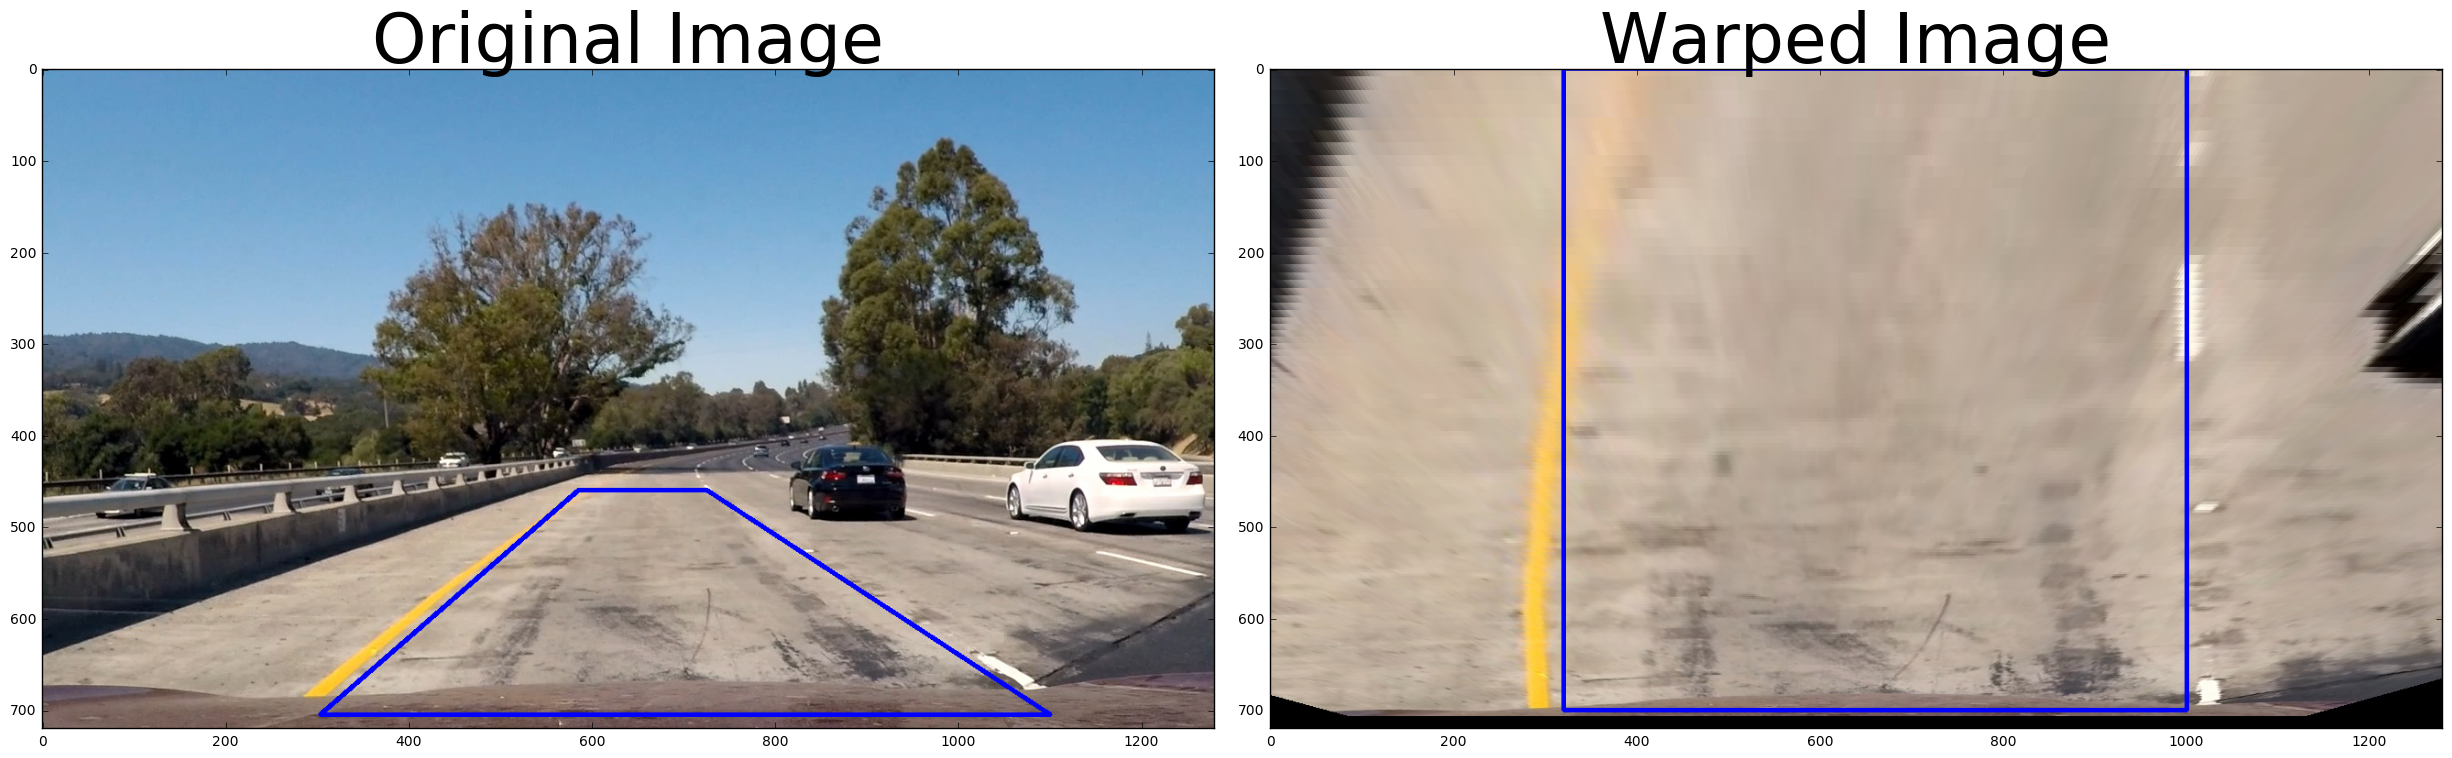

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

img = cv2.line(img, (src_in[0][0],src_in[0][1]), (src_in[1][0],src_in[1][1]), color = (0,0,255), thickness=3)
img = cv2.line(img, (src_in[1][0],src_in[1][1]), (src_in[2][0],src_in[2][1]), color = (0,0,255), thickness=3)
img = cv2.line(img, (src_in[2][0],src_in[2][1]), (src_in[3][0],src_in[3][1]), color = (0,0,255), thickness=3)
img = cv2.line(img, (src_in[3][0],src_in[3][1]), (src_in[0][0],src_in[0][1]), color = (0,0,255), thickness=3)

img_warped = cv2.line(img_warped, (dst_in[0][0],dst_in[0][1]), (dst_in[1][0],dst_in[1][1]), color = (0,0,255), thickness=3)
img_warped = cv2.line(img_warped, (dst_in[1][0],dst_in[1][1]), (dst_in[2][0],dst_in[2][1]), color = (0,0,255), thickness=3)
img_warped = cv2.line(img_warped, (dst_in[2][0],dst_in[2][1]), (dst_in[3][0],dst_in[3][1]), color = (0,0,255), thickness=3)
img_warped = cv2.line(img_warped, (dst_in[3][0],dst_in[3][1]), (dst_in[0][0],dst_in[0][1]), color = (0,0,255), thickness=3)

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [21]:
import matplotlib.patches as patches
from matplotlib.path import Path

In [22]:
binary_warped = warped[0]

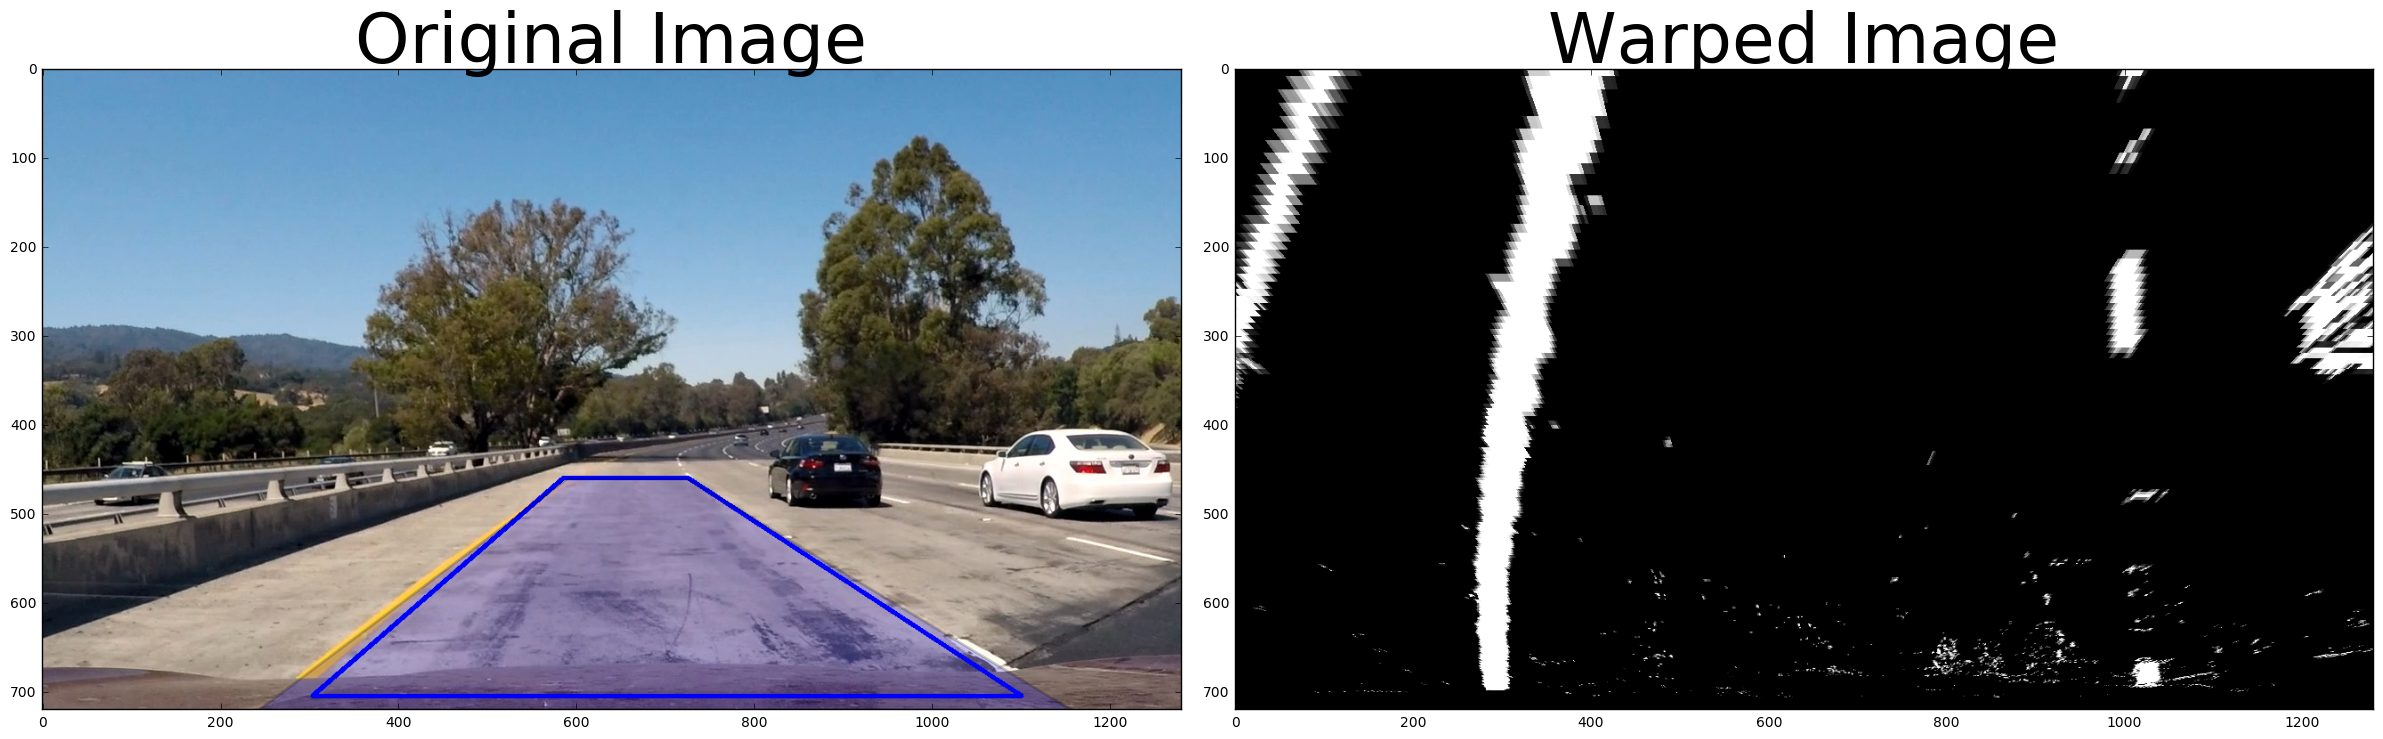

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

src = [((img_size[0] / 2.) - 50, img_size[1] / 2. + 100),
(((img_size[0] / 6.) ) + 30, img_size[1]), 
((img_size[0] * 5 / 6.) + 90, img_size[1]),
((img_size[0] / 2. + 85), img_size[1] / 2. + 100),
((img_size[0] / 2.) - 50, img_size[1] / 2. + 100)]


dst = [((img_size[0] / 4.), 0),
 ((img_size[0] / 4.), img_size[1]),
((img_size[0] * 3 / 4.), img_size[1]),
((img_size[0] * 3 / 4.), 0),
      ((img_size[0] / 4.), 0)]

path = Path(src, codes)

#patch = patches.PathPatch(path, facecolor='orange', lw=2)
patch = patches.PathPatch(path, lw=2,alpha=0.2)
ax1.add_patch(patch)

path = Path(dst, codes)

#patch = patches.PathPatch(path, facecolor='orange', lw=2)
patch = patches.PathPatch(path, lw=4,alpha=0)
ax2.add_patch(patch)

##### Following histogram shows the peaks corresponding to the left and right lanes.

C:\Users\navneet123\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


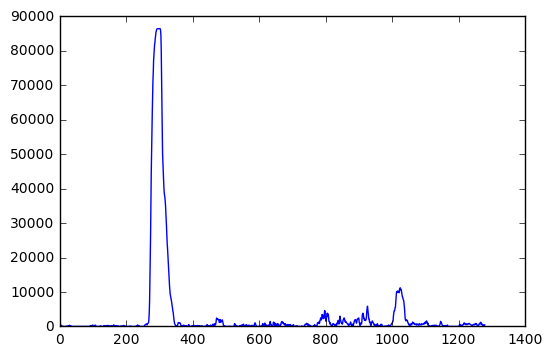

In [24]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

##### Following function is used to draw windows along left and right tracks. 9 windows are drawn along the the tracks. Histogram is used to identify the middle points of left and right lanes. windows are drawn around these mid points. Non zero points are identified within this rectangle and mean of these points is used to find the center of next window on top of the first window at bottom. 9 windows are drawn on top of the each from bottom to top for each left and right tracks.

In [25]:
def getLeftAndRightTracks(binary_warped,drawRectangle):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)    
    window_width = 80 #80

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base  

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if drawRectangle:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

  
    #return out_img, left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty
    return out_img, left_lane_inds, right_lane_inds
    

##### Following function is used to fit a second order polynomial through left and right tracks.

In [26]:
avgFrames = 25

left_0=np.zeros(avgFrames)
left_1=np.zeros(avgFrames)
left_2=np.zeros(avgFrames)

right_0=np.zeros(avgFrames)
right_1=np.zeros(avgFrames)
right_2=np.zeros(avgFrames)

prev_left_0 = 0
prev_left_1 = 0
prev_left_2 = 0

prev_right_0 = 0
prev_right_1 = 0
prev_right_2 = 0

def fitPoly(binary_warped, out_img, left_lane_inds, right_lane_inds,iCount):
    
    
    global countImages
    global avgFrames
    
    global left_0
    global left_1
    global left_2
    
    global right_0
    global right_1
    global right_2
    
    global prev_left_0
    global prev_left_1
    global prev_left_2

    global prev_right_0
    global prev_right_1
    global prev_right_2   
    
   
    # Extract left and right line pixel positions
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])  
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if iCount == 0:
        iCount = 1        
    else:
        left_fit[0] = (left_fit[0] + prev_left_0)/2.
        left_fit[1] = (left_fit[1] + prev_left_1)/2.
        left_fit[2] = (left_fit[2] + prev_left_2)/2.
        
        right_fit[0] = (right_fit[0] + prev_right_0)/2.
        right_fit[1] = (right_fit[1] + prev_right_1)/2.
        right_fit[2] = (right_fit[2] + prev_right_2)/2.        

    prev_left_0 = left_fit[0]
    prev_left_1 = left_fit[1]
    prev_left_2 = left_fit[2]

    left_0[iCount] = left_fit[0]
    left_1[iCount] = left_fit[1]
    left_2[iCount] = left_fit[2]
    
    prev_right_0 = right_fit[0]
    prev_right_1 = right_fit[1]
    prev_right_2 = right_fit[2]  


    right_0[iCount] = right_fit[0]
    right_1[iCount] = right_fit[1]
    right_2[iCount] = right_fit[2]    

    if iCount == avgFrames - 1:
        left_fit[0] = left_0.mean()
        left_fit[1] = left_1.mean()
        left_fit[2] = left_2.mean()   
        
        right_fit[0] = right_0.mean()
        right_fit[1] = right_1.mean()
        right_fit[2] = right_2.mean() 

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
   
    return out_img, left_fitx, right_fitx, ploty, left_fit,right_fit

C:\Users\navneet123\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(720, 0)

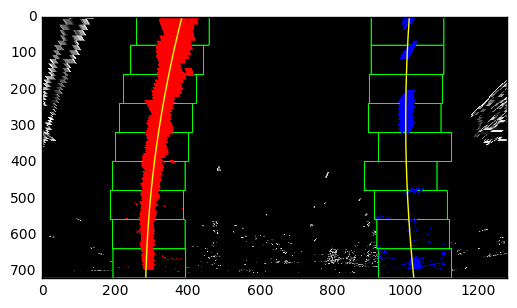

In [27]:
out_img, left_lane_inds, right_lane_inds = getLeftAndRightTracks(binary_warped,True)
out_img, left_fitx, right_fitx, ploty,left_fit,right_fit = fitPoly(binary_warped, out_img, left_lane_inds, right_lane_inds,0)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


C:\Users\navneet123\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(720, 0)

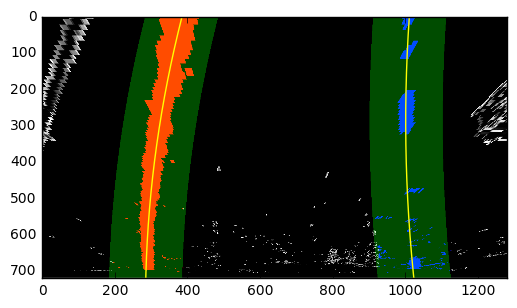

In [28]:
'''
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
'''
out_img, left_lane_inds, right_lane_inds = getLeftAndRightTracks(binary_warped,False)
out_img, left_fitx, right_fitx, ploty,left_fit,right_fit = fitPoly(binary_warped, out_img, left_lane_inds, right_lane_inds,0)
window_img = np.zeros_like(out_img)
margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

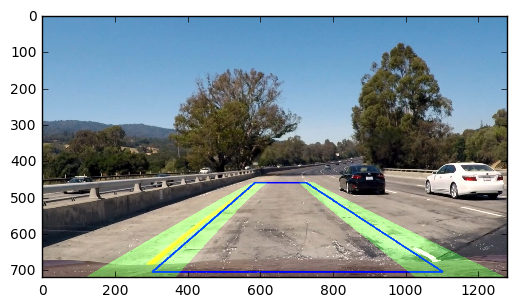

In [29]:
out_img_new = cv2.fillPoly(out_img, np.int_([left_line_pts]), (0,255, 0))
out_img_new = cv2.fillPoly(out_img_new, np.int_([right_line_pts]), (0,255, 0))

out_img_new = cv2.warpPerspective(out_img_new, MInv, img_size,flags=cv2.INTER_NEAREST) 


resultImg = cv2.addWeighted(img, 1, out_img_new, 0.3, 0)
plt.imshow(resultImg)

##### Following function Process_image is called for each frame of video and it uses the already created functions to generate binary warped image and fit a polynomial.

In [32]:
iCount = 0

def process_image(image):   
    
    global iCount      
    
    src_in = np.float32([[585, 460], [303, 705], [1027, 705], [695, 460]])
    dst_in = np.float32([[320, 0], [320, 700], [960,700], [960, 0]])   
    
    #src_in = np.float32([[585, 455], [303, 705], [1027, 705], [695, 455]])
    #dst_in = np.float32([[320, 0], [320, 700], [960,700], [960, 0]])     
 
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255)) # 80,100
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255)) # 80,120
    color_binary = color_threshold(img, sobel_kernel=ksize, threshS = (100,255), threshV = (50,255))

    combined_SVgradXY = np.zeros_like(gradx)
    combined_SVgradXY[((gradx == 1) & (grady == 1)) | ((color_binary == 1))] = 255 
    
    warped = warper(combined_SVgradXY, nx, ny, src_in, dst_in, mtx, dist)
    
    binary_warped = warped[0]
    M = warped[1]
    revM = warped[2]
    
    out_img, left_lane_inds, right_lane_inds = getLeftAndRightTracks(binary_warped,False)
    out_img, left_fitx, right_fitx, ploty,left_fit,right_fit = fitPoly(binary_warped, out_img, left_lane_inds, right_lane_inds,iCount) 
    
    iCount += 1
    if iCount == avgFrames:
        iCount = 0
    
    #print("left_fitx = ", left_fitx)
    #print("right_fitx = ", right_fitx)
    #print("ploty = ", ploty)
    
    #window_img = np.zeros_like(out_img)
    margin_1 = 0
    margin_2 = 420
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin_1, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin_2, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin_2, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin_1, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

  
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()


    out_img_new =  cv2.fillPoly(out_img, np.int_([left_line_pts]), (0,255, 0)) 
    out_img_new =  cv2.fillPoly(out_img_new, np.int_([right_line_pts]), (0,255, 0)) 
    
    out_img_new = cv2.warpPerspective(out_img_new, revM, img_size,flags=cv2.INTER_NEAREST)
    
    result = cv2.addWeighted(image, 1, out_img_new, 0.3, 0)     
    
     
    # Calculate curvature radius and location of vehicle
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])  
    

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    


    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2.0
    center_diff = (camera_center - binary_warped.shape[1]/2) * xm_per_pix
    side_pos = 'left'
    if center_diff <=0 :
        side_pos = 'right'
    
    cv2.putText(result, 'Radius of Curvature = ' + str(round(left_curverad,3)) + '(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)    
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)    

    
    return result
    


In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
movie_output = 'movie.mp4'
#movie_output = 'movie_challenge.mp4'
#movie_output = 'movie_harder_challenge.mp4'
clip1 = VideoFileClip("project_video.mp4")#challenge_video
#clip1 = VideoFileClip("challenge_video.mp4")#challenge_video # harder_challenge_video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(movie_output, audio=False)

C:\Users\navneet123\Anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
C:\Users\navneet123\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app



MoviePy: building video file movie.mp4
----------------------------------------

Writing video into movie.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

C:\Users\navneet123\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Done writing video in movie.mp4 !
Your video is ready !
Wall time: 8min 18s
